<a href="https://colab.research.google.com/github/Ignacio-Ibarra/NLP-Disasters/blob/master/Copia_de_TP1_cambios_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from wordcloud import WordCloud
import PIL
import itertools
from collections import defaultdict
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import string
import re
from PIL import Image    # to import the image
from google.colab import files
from nltk.util import ngrams # function for making ngrams
import collections

sns.set_context('paper',font_scale=1.5)




%matplotlib inline

#para suprimir notacion cientifica en los outputs
pd.options.display.float_format='{:20,.2f}'.format

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Google Drive

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
link='https://drive.google.com/open?id=1Wuo42Fju9VOh2m5PV7q95TTUAIkrEwDD'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1Wuo42Fju9VOh2m5PV7q95TTUAIkrEwDD


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv')

# Carga DF

In [7]:
#Loading 'train.csv' into DataFrame
train=pd.read_csv('train.csv')
train.head(10) #Let's have a first view of the DataFrame

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


# Primer análisis

In [8]:
print('El DataFrame cuenta con {} filas y {} columnas'.format(train.shape[0],train.shape[1]))

El DataFrame cuenta con 7613 filas y 5 columnas


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Se observa que no se tienen todos los keywords ni todas las locations. A esos objetos se les asignarán los valores "no_keyword" y "no_location" respectivamente

In [0]:
train['keyword']=train['keyword'].fillna('no_keyword')
train['location']=train['location'].fillna('no_location')

Analicemos "location" y veamos si tiene sentido mantenerlo en el análisis...

In [11]:
locations=train.location.value_counts()
print('El {} % de los locations son valores únicos en el DF'.format(((locations==1).value_counts(normalize=True))[1]*100))

El 84.32076600837821 % de los locations son valores únicos en el DF


El 84.32% de los locations son valores únicos en el DF. Esto se debe a que la ubicación es un input que genera el usuario. No se considerará esta columna en el análisis exploratorio

# Cleaning de tweets repetidos

Pasos del cleaning:


1.   En columna 'text', identificar strings repetidos
2.   Para los strings identificados en el punto 1, identificar los que tengan 2 targets distintos
3. Eliminar las filas identificadas en el punto 2
4. Generar un nuevo DF (train_no_duplicates), con una columna que indique cantidad de repeticiones de cada 'text'(con target único)
5. Descartar las repeticiones de 'text' salvo por la primera ocurrencia
6. Eliminar mentions y urls de cada 'text' y asignar los resultados a una nueva columna 'text_clean'
7. Eliminar signos de puntuación y caracteres especiales de cada 'text_clean'
8. Para 'text_clean' repetir los pasos 1-5 dentro del DF train_no_duplicates.




Se busca ver si los textos se repiten o no, y en caso de repetirse si contienen targets distintos.

In [12]:
duplicated=train.groupby(['text']).agg({'target':['count','nunique']}).reset_index()
duplicated.sort_values(by=('target','count'),ascending=False)

text target        
                                                         count nunique
646   11-Year-Old Boy Charged With Manslaughter of T...     10       1
45    #Bestnaijamade: 16yr old PKK suicide bomber wh...      6       1
6131  The Prophet (peace be upon him) said 'Save you...      6       2
3589  He came to a land which was engulfed in tribal...      6       2
4589  Madhya Pradesh Train Derailment: Village Youth...      5       1
...                                                 ...    ...     ...
2507  Bamenda Floods Kill Animals Birds - http://t.c...      1       1
2506  Baltimore City : I-95 NORTH AT MP 54.8 (FORT M...      1       1
2505  Bairstow dropped his buffet ticket there. Deva...      1       1
2504                                            Bad day      1       1
7502  åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...      1       1

[7503 rows x 3 columns]

Se observa que hay tweets que se repiten hasta 10 veces. A su vez, existen tweets a los que se les asignaron 2 targets al mismo tiempo (columna nunique). Esos datos se deben eliminar ya que afectan al set de entrenamiento.

Incorporaremos una columna donde diga cuántas veces se repiten los tweets. 

In [0]:
train_no_duplicates=train
duplicate_texts=train_no_duplicates.loc[:,['text','target']].groupby(['text']).transform('count')
train_no_duplicates['duplicate_text_count']=duplicate_texts


Eliminamos los textos duplicados con tweets contradictorios


In [0]:
contradiction=train_no_duplicates.loc[:,['text','target']].groupby(['text']).transform('nunique')
train_no_duplicates['count_targets']=contradiction
train_no_duplicates=train_no_duplicates[train.count_targets==1]
train_no_duplicates.drop('count_targets',axis=1,inplace=True)

Una vez eliminados los tweets contradictorios, se eliminan los tweets duplicados (salvo la primera ocurrencia)

In [0]:
train_no_duplicates.drop_duplicates(subset ='text', keep = 'first', inplace = True)

In [384]:
print('El DataFrame post cleaning cuenta con {} filas y {} columnas'.format(train_no_duplicates.shape[0],train.shape[1]))

El DataFrame post cleaning cuenta con 7485 filas y 7 columnas


Se eliminan urls y mentions de cada 'text'

In [0]:
def cleanText(inputString):
  text = re.sub(r'http\S+', '', inputString)  
  text2 = re.sub(r'@\S+', '', text)
  text3 = re.sub(r'&\S+', '', text2)
  text4 = re.sub(r'Ã\S+', '', text3)
  text5 = re.sub(r'www\S+','',text4)
    
  return (text5)
 
train_no_duplicates['text_clean'] = train_no_duplicates['text'].apply(lambda x: cleanText(x))


Se eliminan los signos de puntuación


In [0]:
def deletePunctuation(inputString):
  aux=string.punctuation
  special_characters='ÃŒ©‰¥¼ªû'
  #puncts=aux.translate(str.maketrans("#@:/.","     "))
  auxstring=" " * len(aux)
  auxstring2=" " * len(special_characters)
  outputString=inputString.translate(str.maketrans(aux,auxstring))
  outputString=outputString.translate(str.maketrans(special_characters,auxstring2))
  return outputString

train_no_duplicates['text_clean'] = train_no_duplicates['text_clean'].apply(lambda x:deletePunctuation(x))

In [18]:
train_no_duplicates.head(20)

,id,keyword,location,text,target,duplicate_text_count,text_clean
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,1,Our Deeds are the Reason of this earthquake M...
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,1,Forest fire near La Ronge Sask Canada
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,1,All residents asked to shelter in place are ...
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,1,13 000 people receive wildfires evacuation or...
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,1,Just got sent this photo from Ruby Alaska as ...
5,8,no_keyword,no_location,#RockyFire Update => California Hwy. 20 closed...,1,1,RockyFire Update California Hwy 20 closed...
6,10,no_keyword,no_location,#flood #disaster Heavy rain causes flash flood...,1,1,flood disaster Heavy rain causes flash flood...
7,13,no_keyword,no_location,I'm on top of the hill and I can see a fire in...,1,1,I m on top of the hill and I can see a fire in...
8,14,no_keyword,no_location,There's an emergency evacuation happening now ...,1,1,There s an emergency evacuation happening now ...
9,15,no_keyword,no_location,I'm afraid that the tornado is coming to our a...,1,1,I m afraid that the tornado is coming to our a...


Se debe repetir el mismo análisis de tweets duplicados

In [19]:
duplicated_clean=train_no_duplicates.groupby(['text_clean']).agg({'target':['count','nunique']}).reset_index()
duplicated_clean=duplicated_clean.sort_values(by=('target','count'),ascending=False)
duplicated_clean

text_clean target        
                                                         count nunique
6241  Watch This Airport Get Swallowed Up By A Sands...     24       1
6467  Wreckage  Conclusively Confirmed  as From MH37...     20       1
3151  Families to sue over Legionnaires  More than 4...     19       1
1583   hot  Funtenna  hijacking computers to send da...     17       2
2728  Christian Attacked by Muslims at the Temple Mo...     15       1
...                                                 ...    ...     ...
2332  Another hour  It s August 05 2015 at 08 02PM H...      1       1
2331  Another fake hate crime Lesbians burn their ow...      1       1
2330  Another entity forced to close in Montego Bay ...      1       1
2329  Another day has passed and THANKFULLY Central ...      1       1
6939  åÈMGN AFRICAå¨ pin 263789F4 åÈ Correction  Ten...      1       1

[6940 rows x 3 columns]

Se agrega una columna que especifique cuantos text_clean se repiten

In [20]:
duplicate_texts_clean=train_no_duplicates.loc[:,['text_clean','target']].groupby(['text_clean']).transform('count')
train_no_duplicates['duplicate_text_clean_count']=duplicate_texts_clean
train_no_duplicates

,id,keyword,location,text,target,duplicate_text_count,text_clean,duplicate_text_clean_count
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,1,Our Deeds are the Reason of this earthquake M...,1
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,1,Forest fire near La Ronge Sask Canada,1
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,1,All residents asked to shelter in place are ...,1
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,1,13 000 people receive wildfires evacuation or...,1
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,1,Just got sent this photo from Ruby Alaska as ...,1
...,...,...,...,...,...,...,...,...
7604,10863,no_keyword,no_location,#WorldNews Fallen powerlines on G:link tram: U...,1,1,WorldNews Fallen powerlines on G link tram U...,1
7605,10864,no_keyword,no_location,on the flip side I'm at Walmart and there is a...,1,1,on the flip side I m at Walmart and there is a...,1
7606,10866,no_keyword,no_location,Suicide bomber kills 15 in Saudi security site...,1,1,Suicide bomber kills 15 in Saudi security site...,1
7608,10869,no_keyword,no_location,Two giant cranes holding a bridge collapse int...,1,1,Two giant cranes holding a bridge collapse int...,8


Eliminar los que tienen targets contradictorios

In [0]:
contradiction_clean=train_no_duplicates.loc[:,['text_clean','target']].groupby(['text_clean']).transform('nunique')
train_no_duplicates['count_targets']=contradiction_clean
train_no_duplicates=train_no_duplicates[train_no_duplicates.count_targets==1]
train_no_duplicates.drop('count_targets',axis=1,inplace=True)

Elimino rows de duplicados salvo primera ocurrencia

In [0]:
train_no_duplicates.drop_duplicates(subset ='text_clean', keep = 'first', inplace = True)

In [24]:
print('El DataFrame post cleaning cuenta con {} filas y {} columnas'.format(train_no_duplicates.shape[0],train.shape[1]))

El DataFrame post cleaning cuenta con 6889 filas y 7 columnas


# Eliminación de stopwords

In [0]:
def deleteStopwords(inputString):
  inputString= inputString.lower()
  text_tokens = word_tokenize(inputString)
  tokens_without_sw = [word for word in text_tokens if not word in stopwords.words('english')]
  filtered_sentence = (" ").join(tokens_without_sw)
  return filtered_sentence

train_no_duplicates['text_clean_no_sw'] = train_no_duplicates['text_clean'].apply(lambda x:deleteStopwords(x))

# Proporción de Target Real/Not Real

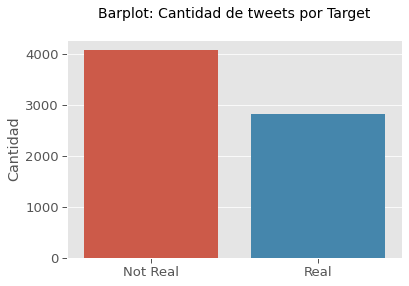

In [26]:
#Cantidad de registros

x=train_no_duplicates['target'].value_counts()
g=sns.barplot(x.index,x)
g.set_title('Barplot: Cantidad de tweets por Target\n',fontsize=14)
g.set_ylabel('Cantidad')
plt.xticks([0, 1], ['Not Real', 'Real'])
plt.show()


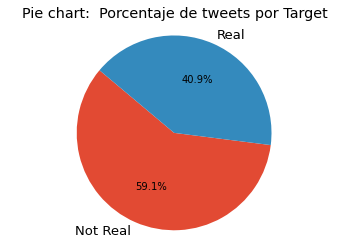

In [27]:
labels='Not Real','Real'
g2=plt.pie(x,labels=labels,autopct='%1.1f%%',startangle=140)
plt.axis('equal')
plt.title('Pie chart:  Porcentaje de tweets por Target')
plt.show()


Se observa mayor proporción de tweets de clase "Not Real" sobre los de clase "Real". 

Se puede dividir el DF en 2 subsets

In [0]:
train1=train_no_duplicates[train_no_duplicates['target']==1]
train0=train_no_duplicates[train_no_duplicates['target']==0]

# Análisis de Keywords

In [0]:
def percent_real_disaster(x):
    return x.mean()*100 


grouped=train_no_duplicates.groupby(['keyword']).agg({'target':[percent_real_disaster]}).sort_values(by=('target','percent_real_disaster'),ascending=False)
grouped=grouped.reset_index()


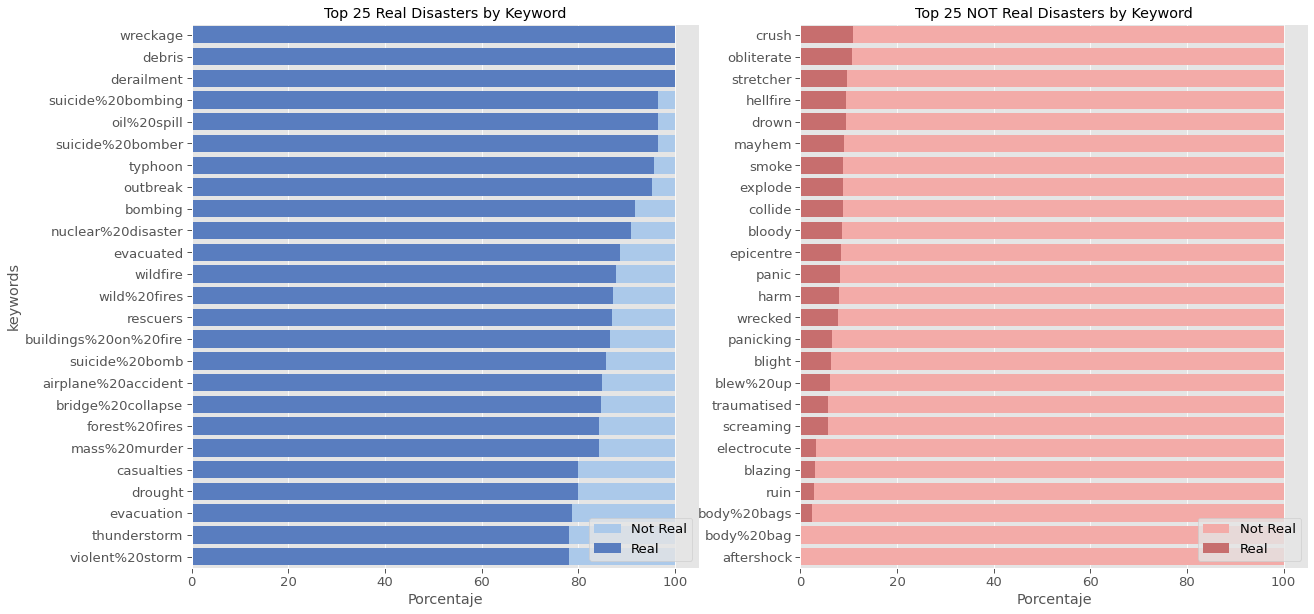

In [30]:
#Plot 
#Ploteo el total de tweets por keyword
f, axes = plt.subplots(1,2, figsize=(20, 10), sharex=True)

#Los keywords con mayor proporción de tweets Reales
sns.set_color_codes("pastel")
g1=sns.barplot(ax=axes[0],x=100,y='keyword',data=grouped.head(25),label='Not Real', color="b")
sns.set_color_codes("muted")
sns.barplot(ax=axes[0],x=('target','percent_real_disaster'),y='keyword',data=grouped.head(25), label='Real',color="b")
g1.set_ylabel('keywords')
g1.set_xlabel('Porcentaje')
g1.set_title('Top 25 Real Disasters by Keyword')

#los peores 10
sns.set_color_codes("pastel")
g2=sns.barplot(ax=axes[1],x=100,y='keyword',data=grouped.tail(25), label='Not Real',color="r")
sns.set_color_codes("muted")
sns.barplot(ax=axes[1],x=('target','percent_real_disaster'),y='keyword',data=grouped.tail(25),label='Real', color="r")
g2.set_ylabel('')
g2.set_xlabel('Porcentaje')
g2.set_title('Top 25 NOT Real Disasters by Keyword')

# Legend
g1.legend(ncol=1, loc="lower right", frameon=True)
g2.legend(ncol=1, loc="lower right", frameon=True)

plt.show()

En la figura se la izquiera se ilustran 25 keywords con porcentajes de Target "Real" mayores al 75%. Se observan keywords referentes a desastres naturales (*drought, forest fire, violent storm)* o edilicios (*bridge collapse, buildings on fire*). También se encuentran tragedias mortales (*mass murder, airplane accident, nuclear disaster, suicide bombing*). Otros keywords incluyen lenguaje de noticias (*casualties, evacuated, rescuers*). 

Por otro lado, en la figura de la derecha, se observan los 25 keywords con menores porcentajes de veracidad. En su mayoría se trata de palabras que servirían para describir tragedias pero que a su vez pueden usarse en muchos otros contextos. Un ejemplo de esto es el keyword "body bag", con un porcentaje de targets Reales menor al 5%. El término por si solo sonaría alarmante, pero veamos las acepciones de la palabra:

1.   Bolsa para guardar cadáveres
2.   Una clase de cartera/mochila
3.   Según *Urban Dictionary*, "To boddybag an oponent" es asegurar la victoria sobre el oponente (algo así como "kick ass"), slang muy utilizado en las batallas de rap.
4.   Otra acepción de *Urban Dictionary*, "Bodybagging" es robarle un chiste a otro comediante y hacerlo pasar como propio. 

Se observa también mayor cantidad de verbos y adjetivos que en el otro target.




# Análisis de características de tweets

In [0]:
def Numbers_count(inputString):
  count=0
  i=0
  inputString=inputString.split()
  while i < len(inputString):
    if inputString[i].isdigit() == True:
      count=count+1
    i=i+1
    return count

train_no_duplicates['url_count'] = train_no_duplicates['text'].apply(lambda x: len([w for w in str(x).lower().split() if ('http' or 'www') in w]))
train_no_duplicates['hashtag_count'] = train_no_duplicates['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
train_no_duplicates['mention_count'] = train_no_duplicates['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
train_no_duplicates['digits_count'] = train_no_duplicates['text_clean'].apply(lambda x: Numbers_count(x))
train_no_duplicates['characters_count'] = train_no_duplicates['text'].apply(lambda x: len(str(x)))
train_no_duplicates['characters_count_clean'] = train_no_duplicates['text_clean'].apply(lambda x: len(str(x)))
train_no_duplicates['characters_count_clean_sw'] = train_no_duplicates['text_clean_no_sw'].apply(lambda x: len(str(x)))
train_no_duplicates['word_count'] = train_no_duplicates['text'].apply(lambda x: len(str(x).split()))
train_no_duplicates['word_count_clean'] = train_no_duplicates['text_clean'].apply(lambda x: len(str(x).split()))
train_no_duplicates['word_count_clean_sw'] = train_no_duplicates['text_clean_no_sw'].apply(lambda x: len(str(x).split()))

In [0]:
cols_stats= ['url_count','hashtag_count','mention_count','digits_count','characters_count','characters_count_clean_sw','word_count','word_count_clean_sw','target']

In [33]:
train_no_duplicates[cols_stats].groupby('target').agg(['mean','std','skew'])

url_count  ...  word_count_clean_sw
                       mean  ...                 skew
target                       ...                     
0                      0.46  ...                 0.20
1                      0.73  ...                 0.23

[2 rows x 24 columns]

In [34]:
(train_no_duplicates.corr())['target']

id                                           0.05
target                                       1.00
duplicate_text_count                         0.05
duplicate_text_clean_count                   0.06
url_count                                    0.20
hashtag_count                                0.08
mention_count                               -0.09
digits_count                                 0.06
characters_count                             0.18
characters_count_clean                       0.13
characters_count_clean_sw                    0.23
word_count                                   0.04
word_count_clean                             0.04
word_count_clean_sw                          0.18
Name: target, dtype: float64

In [35]:
!pip install ptitprince

     |████████████████████████████████| 61kB 3.0MB/s 
  Created wheel for ptitprince: filename=ptitprince-0.2.3-cp36-none-any.whl size=8445 sha256=2b39a57f5a6ba466d5f4e84f0c94bed0c91b108317b5d01ca0dc562648188251
  Stored in directory: /root/.cache/pip/wheels/0a/f8/51/69b54ac713d656ee1a792a3cd5f33deb742156183882b01c10
Successfully built ptitprince


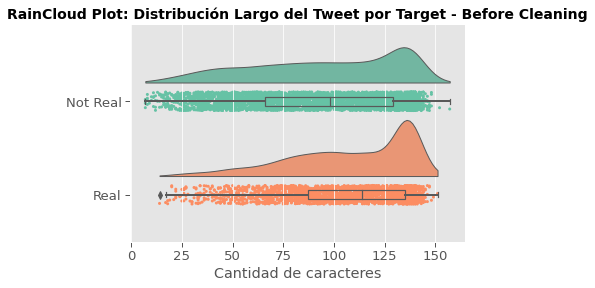

In [36]:
import ptitprince as pt
ax=pt.RainCloud(x='target',y='characters_count',data=train_no_duplicates, showmeans=True,
width_viol=1.2,
width_box=0.1,
figsize=(8,15),
orient='h')
ax.set_title('RainCloud Plot: Distribución Largo del Tweet por Target - Before Cleaning',fontsize=14,fontweight='bold')
ax.set_xlabel('Cantidad de caracteres')
ax.set_ylabel('')
plt.yticks([0, 1], ['Not Real', 'Real'])
plt.show()

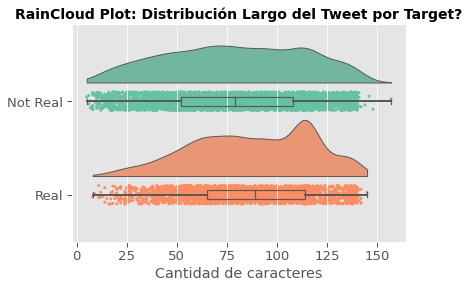

In [37]:
import ptitprince as pt
ax=pt.RainCloud(x='target',y='characters_count_clean',data=train_no_duplicates, showmeans=True,
width_viol=1.2,
width_box=0.1,
figsize=(8,15),
orient='h')
ax.set_title('RainCloud Plot: Distribución Largo del Tweet por Target?',fontsize=14,fontweight='bold')
ax.set_xlabel('Cantidad de caracteres')
ax.set_ylabel('')
plt.yticks([0, 1], ['Not Real', 'Real'])
plt.show()

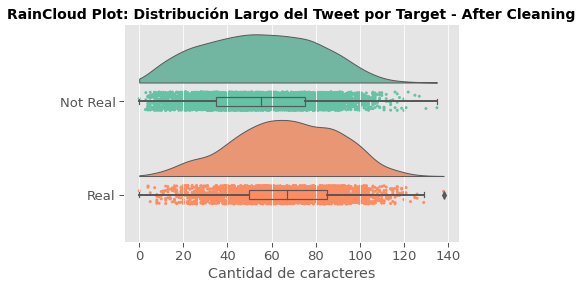

In [38]:
import ptitprince as pt
ax=pt.RainCloud(x='target',y='characters_count_clean_sw',data=train_no_duplicates, showmeans=True,
width_viol=1.2,
width_box=0.1,
figsize=(8,15),
orient='h')
ax.set_title('RainCloud Plot: Distribución Largo del Tweet por Target - After Cleaning',fontsize=14,fontweight='bold')
ax.set_xlabel('Cantidad de caracteres')
ax.set_ylabel('')
plt.yticks([0, 1], ['Not Real', 'Real'])
plt.show()

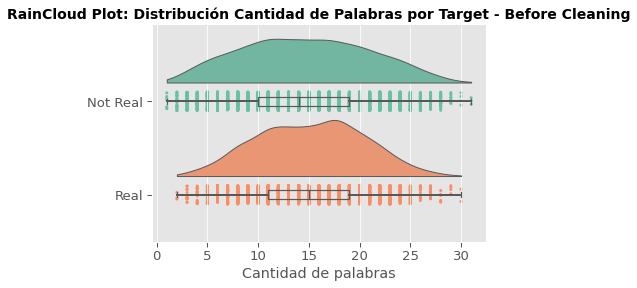

In [39]:
ax=pt.RainCloud(x='target',y='word_count',data=train_no_duplicates, showmeans=True,
width_viol=1.2,
width_box=0.1,
figsize=(8,15),
orient='h')
ax.set_title('RainCloud Plot: Distribución Cantidad de Palabras por Target - Before Cleaning',fontsize=14,fontweight='bold')
ax.set_xlabel('Cantidad de palabras')
ax.set_ylabel('')
plt.yticks([0, 1], ['Not Real', 'Real'])
plt.show()

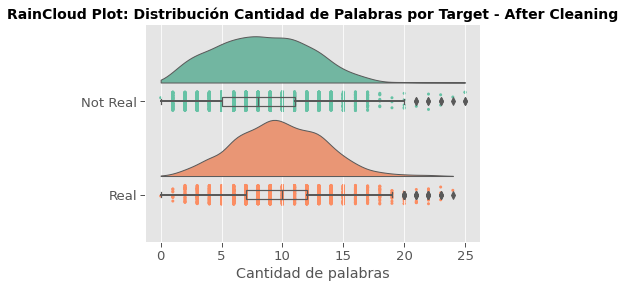

In [40]:
ax=pt.RainCloud(x='target',y='word_count_clean_sw',data=train_no_duplicates, showmeans=True,
width_viol=1.2,
width_box=0.1,
figsize=(8,15),
orient='h')
ax.set_title('RainCloud Plot: Distribución Cantidad de Palabras por Target - After Cleaning',fontsize=14,fontweight='bold')
ax.set_xlabel('Cantidad de palabras')
ax.set_ylabel('')
plt.yticks([0, 1], ['Not Real', 'Real'])
plt.show()

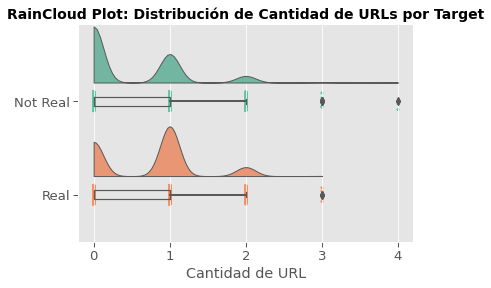

In [41]:
#Comparamos las distribuciones de url count por target. 
import ptitprince as pt
ax=pt.RainCloud(x='target',y='url_count',data=train_no_duplicates, showmeans=True,
width_viol=1.2,
width_box=0.1,
figsize=(8,15),
orient='h')
ax.set_title('RainCloud Plot: Distribución de Cantidad de URLs por Target',fontsize=14,fontweight='bold')
ax.set_xlabel('Cantidad de URL')
ax.set_ylabel('')
plt.yticks([0, 1], ['Not Real', 'Real'])
plt.show()



In [42]:
#Veamos la correlación entre estas dos variables. 
train_no_duplicates[['target','url_count']].corr()

,target,url_count
target,1.00,0.20
url_count,0.20,1.00


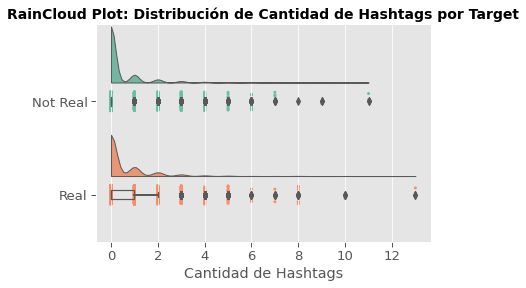

In [43]:
#Comparamos la distribuciones de hashtags por target. 
import ptitprince as pt
ax=pt.RainCloud(x='target',y='hashtag_count',data=train_no_duplicates, showmeans=True,
width_viol=1.2,
width_box=0.1,
figsize=(8,15),
orient='h')
ax.set_title('RainCloud Plot: Distribución de Cantidad de Hashtags por Target',fontsize=14,fontweight='bold')
ax.set_xlabel('Cantidad de Hashtags')
ax.set_ylabel('')
plt.yticks([0, 1], ['Not Real', 'Real'])
plt.show()

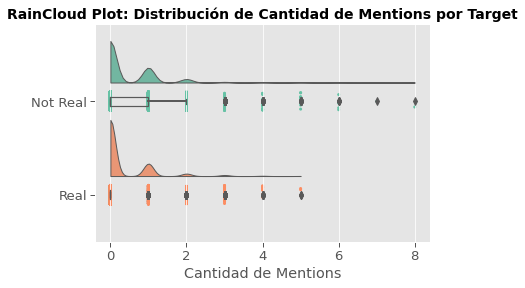

In [44]:
#Comparamos la distribuciones de mentions_count por target. 
import ptitprince as pt
ax=pt.RainCloud(x='target',y='mention_count',data=train_no_duplicates, showmeans=True,
width_viol=1.2,
width_box=0.1,
figsize=(8,15),
orient='h')
ax.set_title('RainCloud Plot: Distribución de Cantidad de Mentions por Target',fontsize=14,fontweight='bold')
ax.set_xlabel('Cantidad de Mentions')
ax.set_ylabel('')
plt.yticks([0, 1], ['Not Real', 'Real'])
plt.show()

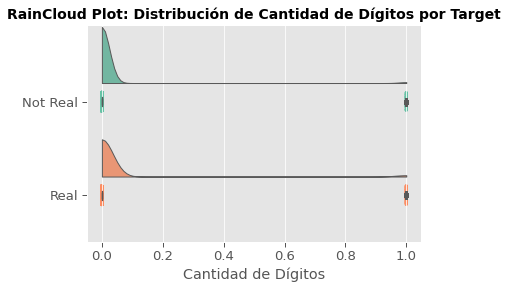

In [45]:
#Comparamos la distribuciones de digits_count por target. 
import ptitprince as pt
ax=pt.RainCloud(x='target',y='digits_count',data=train_no_duplicates, showmeans=True,
width_viol=1.2,
width_box=0.1,
figsize=(8,15),
orient='h')
ax.set_title('RainCloud Plot: Distribución de Cantidad de Dígitos por Target',fontsize=14,fontweight='bold')
ax.set_xlabel('Cantidad de Dígitos')
ax.set_ylabel('')
plt.yticks([0, 1], ['Not Real', 'Real'])
plt.show()

In [46]:
#Value Counts de digits_count
train_no_duplicates.digits_count.value_counts(normalize=True)

0                   0.98
1                   0.02
Name: digits_count, dtype: float64

#Analisis de Stopwords 

In [0]:
sw = stopwords.words("english")

def generate_tokens(target):
    text_tokens=[]
    for x in train_no_duplicates[train_no_duplicates['target']==target]['text_clean'].str.split():
        for i in x:
            text_tokens.append(i)
    return text_tokens

#Analizo stopwords para target Not Real
tokens_0=generate_tokens(0)

dic=defaultdict(int)

for word in tokens_0:
    if word in sw:
        dic[word]+=1

stopwords_0=dic


#Analizo stopwords para target Real

tokens_1=generate_tokens(1)

dic=defaultdict(int)

for word in tokens_1:
    if word in sw:
        dic[word]+=1

stopwords_1=dic


In [0]:
stopwords_0=pd.DataFrame.from_dict(stopwords_0,orient='index').reset_index()
stopwords_1=pd.DataFrame.from_dict(stopwords_1,orient='index').reset_index()

In [0]:
stopwords_merged=pd.merge(stopwords_0,stopwords_1,how='outer',on='index')

In [0]:
stopwords_merged.columns=['stopwords','target_0','target_1']

In [0]:
stopwords_merged['target_0']=pd.to_numeric(stopwords_merged.target_0)
stopwords_merged['target_1']=pd.to_numeric(stopwords_merged.target_1)

In [52]:
stopwords_merged.target_0.fillna(0,inplace=True)
stopwords_merged.target_1.fillna(0,inplace=True)
stopwords_merged

,stopwords,target_0,target_1
0,s,522.00,296.00
1,up,180.00,85.00
2,is,494.00,284.00
3,so,185.00,48.00
4,a,"1,088.00",690.00
...,...,...,...
142,ourselves,2.00,0.00
143,above,4.00,2.00
144,theirs,1.00,0.00
145,hers,0.00,1.00


In [0]:
stopwords_merged['total_count']=stopwords_merged['target_0']+stopwords_merged['target_1']
stopwords_merged['truthfulness']=stopwords_merged['target_1']/stopwords_merged['total_count']

In [54]:
#Le pido que me muestre cuando target_1 es mayor a target_0
stopwords_merged[stopwords_merged.loc[:,'target_1']>stopwords_merged.loc[:,'target_0']].sort_values(by='total_count', ascending=False).head(20)

,stopwords,target_0,target_1,total_count,truthfulness
9,in,692.00,890.00,"1,582.00",0.56
34,at,204.00,244.00,448.00,0.54
67,from,156.00,178.00,334.00,0.53
99,after,61.00,112.00,173.00,0.65
57,over,55.00,76.00,131.00,0.58
86,than,51.00,54.00,105.00,0.51
60,were,30.00,64.00,94.00,0.68
100,during,13.00,29.00,42.00,0.69
85,those,17.00,24.00,41.00,0.59
120,isn,5.00,9.00,14.00,0.64


In [55]:
#Le pido que me muestre cuando target_0 es mayor que target_1
stopwords_merged[stopwords_merged.loc[:,'target_0']>stopwords_merged.loc[:,'target_1']].sort_values(by='total_count', ascending=False).head(20)

,stopwords,target_0,target_1,total_count,truthfulness
13,the,"1,471.00",934.00,"2,405.00",0.39
4,a,"1,088.00",690.00,"1,778.00",0.39
12,to,"1,060.00",633.00,"1,693.00",0.37
27,of,793.00,738.00,"1,531.00",0.48
25,and,810.00,416.00,"1,226.00",0.34
0,s,522.00,296.00,818.00,0.36
2,is,494.00,284.00,778.00,0.37
23,on,388.00,368.00,756.00,0.49
15,for,436.00,304.00,740.00,0.41
11,you,593.00,110.00,703.00,0.16


Falta gráfico acá. 

# Análisis de clase de palabras

Se requiere uso de librería TweetTokenizer para poder interpretar correctamente la clase de cada palabra, dado que no se puede realizar sacando las palabras de su contexto. Hay que hacerlo primero obteniendo los tags para cada fila, luego unificarlos. Los tags provienen del tagset Penn Treebank Tokenization. Hemos agrupado las sub-clases en clases. 


In [0]:
clases_y_subclases = {'noun': [('NN','singular comon noun'), 
                             ('NNP','singular poper noun'),
                             ('NNS', 'plural comon noun'),
                             ('NNPS', 'plural proper noun')],
                      'verb':  [('VB', 'base form verb'),
                              ('VBD', 'past tense verb'),
                              ('VBG','verb, present participle or gerund'),
                              ('VBN', 'verb, past participle'),
                              ('VBP','verb, present tense, not 3rd person singular'), 
                              ('VBZ','verb, present tense, 3rd person singular'),
                              ('MD','modal auxiliary')],
                      'adjetives': [('JJ','adjective or numeral, ordinal'),
                                    ('JJR','adjective, comparative'),
                                    ('JJS','adjective, superlative')],
                      'pronouns': [('PRP','pronoun, personal'),
                                   ('PRP$','pronoun, possessive'),
                                   ('WP','WH-pronoun'),
                                   ('WP$','WH-pronoun, possessive')],
                      'determiners': [('PDT','pre-determiner'),
                                      ('DT','determiner'),
                                      ('WDT','WH-determiner')],
                      'adverbs': [('RB','adverb'),
                                  ('RBR','adverb, comparative'),
                                  ('RBS','adverb, superlative'),
                                  ('RP','particle'),
                                  ('EX','existential there')],
                      'prepositions': [('IN','preposition or conjunction, subordinating'),
                                       ('TO','to as preposition or infinitive marker')],
                      'conjuctions': [('CC','conjunction, coordinating')],
                      'numerals_cardinals': [('CD','numeral, cardinal')],
                      'foreing_words': [('FW','foreing word')],
                      'quotes': [("''",'quotes')],
                      'interjections': [('UH','interjection')],
                      '$': [('$','dolar')],
                      'symbols': [('SYM','symbol')]
}

In [57]:
#Obtenemos el token de cada texto. 
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()
train_no_duplicates['tokenized_text']=train_no_duplicates['text_clean'].apply(lambda x: x.lower()).apply(tt.tokenize) 
train_no_duplicates['tokenized_text']

0       [our, deeds, are, the, reason, of, this, earth...
1           [forest, fire, near, la, ronge, sask, canada]
2       [all, residents, asked, to, shelter, in, place...
3       [13, 000, people, receive, wildfires, evacuati...
4       [just, got, sent, this, photo, from, ruby, ala...
                              ...                        
7602    [a, siren, just, went, off, and, it, wasn, t, ...
7603    [officials, say, a, quarantine, is, in, place,...
7604    [worldnews, fallen, powerlines, on, g, link, t...
7605    [on, the, flip, side, i, m, at, walmart, and, ...
7606    [suicide, bomber, kills, 15, in, saudi, securi...
Name: tokenized_text, Length: 6889, dtype: object

In [58]:
#Para cada token obtenemos el tag (clase de palabra)
train_no_duplicates['pos_tagged_text'] = train_no_duplicates['tokenized_text'].apply(nltk.Text).apply(nltk.pos_tag) #Este paso me transforma la lista en 
#un texto entre paréntesis (que no sé qué es) y luego me arma una lista de tuplas (k,v) con la palabra y la clase de palabra. 
train_no_duplicates['pos_tagged_text'] 

0       [(our, PRP$), (deeds, NNS), (are, VBP), (the, ...
1       [(forest, JJS), (fire, NN), (near, IN), (la, J...
2       [(all, DT), (residents, NNS), (asked, VBD), (t...
3       [(13, CD), (000, CD), (people, NNS), (receive,...
4       [(just, RB), (got, VBN), (sent, VBD), (this, D...
                              ...                        
7602    [(a, DT), (siren, NN), (just, RB), (went, VBD)...
7603    [(officials, NNS), (say, VBP), (a, DT), (quara...
7604    [(worldnews, NNS), (fallen, VBN), (powerlines,...
7605    [(on, IN), (the, DT), (flip, JJ), (side, NN), ...
7606    [(suicide, JJ), (bomber, NN), (kills, NNS), (1...
Name: pos_tagged_text, Length: 6889, dtype: object

In [59]:
#En cada fila contamos la frecuencia de las clases de palabras
from collections import Counter
train_no_duplicates['pos_tagg_counts']=train_no_duplicates['pos_tagged_text'].apply(lambda x: Counter(tag for word,tag in x))
train_no_duplicates['pos_tagg_counts']

0       {'PRP$': 1, 'NNS': 1, 'VBP': 1, 'DT': 3, 'NN':...
1                   {'JJS': 1, 'NN': 4, 'IN': 1, 'JJ': 1}
2       {'DT': 2, 'NNS': 3, 'VBD': 1, 'TO': 1, 'VB': 1...
3          {'CD': 2, 'NNS': 3, 'JJ': 1, 'NN': 2, 'IN': 1}
4       {'RB': 1, 'VBN': 1, 'VBD': 1, 'DT': 2, 'NN': 4...
                              ...                        
7602    {'DT': 2, 'NN': 4, 'RB': 2, 'VBD': 1, 'CC': 1,...
7603    {'NNS': 2, 'VBP': 1, 'DT': 3, 'NN': 6, 'VBZ': ...
7604    {'NNS': 5, 'VBN': 2, 'IN': 1, 'NN': 4, 'JJ': 1...
7605    {'IN': 4, 'DT': 2, 'JJ': 2, 'NN': 5, 'VBP': 2,...
7606       {'JJ': 2, 'NN': 8, 'NNS': 2, 'CD': 1, 'IN': 2}
Name: pos_tagg_counts, Length: 6889, dtype: object

In [60]:
#Creamos un dataframe con la misma cantidad de filas que el dataframe con el que venimos trabajando. 
#Las columnas serán todas las clases de palabras existentes en la librería nltk que estén dentro de nuestras frecuencias. 
data = train_no_duplicates['pos_tagg_counts']
word_classes_df = pd.DataFrame.from_records(data, columns = data.sum().keys())
len(word_classes_df)

6889

In [61]:
#Dicho dataframe posee por fila el dato de la frecuencia para cada clase. 
word_classes_df.fillna(0,inplace=True)
word_classes_df

,PRP$,NNS,VBP,DT,NN,IN,MD,VB,JJ,PRP,JJS,VBD,TO,VBG,VBN,CC,CD,RB,EX,VBZ,WP,RP,JJR,NNP,WRB,$,WDT,RBR,RBS,PDT,FW,SYM,UH,WP$,''
0,1.00,1.00,1.00,3.00,2.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,4.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,3.00,2.00,2.00,4.00,3.00,0.00,1.00,1.00,0.00,0.00,1.00,1.00,1.00,2.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,3.00,0.00,0.00,2.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,1.00,1.00,2.00,4.00,4.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6884,0.00,0.00,0.00,2.00,4.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,2.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6885,0.00,2.00,1.00,3.00,6.00,4.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6886,0.00,5.00,1.00,0.00,4.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,2.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6887,0.00,1.00,2.00,2.00,5.00,4.00,0.00,1.00,2.00,0.00,0.00,1.00,1.00,0.00,0.00,3.00,0.00,3.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [62]:
#Creamos una lista con 6889 elementos, todos integeres desde el 0 al 6888 inclusive, para poder usar como indice de la tabla train_no_duplicates
def create_integers_ascending_list(number_elements): 
  lista=[]
  i=0
  number=0
  while i<number_elements: 
    lista.append(number)
    number=number+1
    i=i+1
  return lista

int_list=create_integers_ascending_list(6889)
len(int_list)

6889

In [0]:
#incorporamos la lista de integers al dataframe
train_no_duplicates['index']=int_list

In [64]:
#Corroboramos que no haya generado nulls. 
train_no_duplicates['index'].isnull().value_counts()

False    6889
Name: index, dtype: int64

In [0]:
#seteamos un nuevo índice en train_no_duplicates para poder hacer el concat. 
train_no_duplicates.set_index('index', inplace=True)

In [66]:
#Obtenemos el nuevo dataframe
train_no_duplicates_merge_word_classes=pd.concat([train_no_duplicates,word_classes_df],axis=1)
train_no_duplicates_merge_word_classes.shape

(6889, 57)

In [142]:
correlation = (train_no_duplicates_merge_word_classes.corr())['target'][14:]

ValueError: ignored

In [147]:
#Variables que tienen correlación mayor a 0.1
correlation[correlation.values>=0.1]

NNS                   0.15
NN                    0.13
IN                    0.13
CD                    0.12
Name: target, dtype: float64

In [146]:
#Varibales que tienen correlación menor a -0.1
correlation[correlation.values<=-0.1]

PRP$                  -0.15
VBP                   -0.10
VB                    -0.13
PRP                   -0.18
RB                    -0.10
Name: target, dtype: float64

<function matplotlib.pyplot.show>

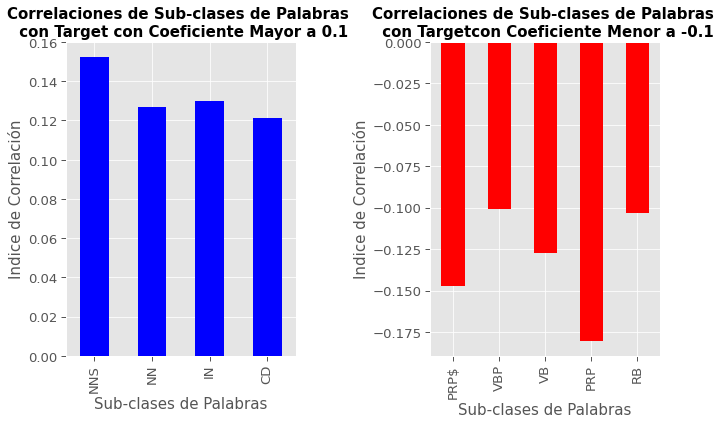

In [156]:
plt.subplot(1, 2, 1)

#Variables que tienen correlación mayor a 0.1
correlation[correlation.values>=0.1].plot(kind='bar', color='blue', figsize=(10,6))
plt.title('Correlaciones de Sub-clases de Palabras \n Coeficiente Mayor a 0.1',fontweight='bold', fontsize=15)
plt.ylabel('Indice de Correlación', fontsize=15)
plt.xlabel('Sub-clases de Palabras', fontsize=15)

plt.subplot(1, 2, 2)

#Varibales que tienen correlación menor a -0.1
correlation[correlation.values<=-0.1].plot(kind='bar', color='red', figsize=(10,6))
plt.title('Correlaciones de Sub-clases de Palabras \n Coeficiente Menor a -0.1',fontweight='bold', fontsize=15)
plt.ylabel('Indice de Correlación', fontsize=15)
plt.xlabel('Sub-clases de Palabras', fontsize=15)

plt.tight_layout()
plt.show

In [84]:
#Armo una lista con todos los nombres de las clases de palabras. 
agg_cols=train_no_duplicates_merge_word_classes.columns[22:].tolist()
agg_cols

['PRP$',
 'NNS',
 'VBP',
 'DT',
 'NN',
 'IN',
 'MD',
 'VB',
 'JJ',
 'PRP',
 'JJS',
 'VBD',
 'TO',
 'VBG',
 'VBN',
 'CC',
 'CD',
 'RB',
 'EX',
 'VBZ',
 'WP',
 'RP',
 'JJR',
 'NNP',
 'WRB',
 '$',
 'WDT',
 'RBR',
 'RBS',
 'PDT',
 'FW',
 'SYM',
 'UH',
 'WP$',
 "''"]

In [0]:
#Construyo la lista de nombres de columnas para poder hacer la agregación sólo sobre ellas. 
agg_cols.append('target')

In [86]:
agg_cols

['PRP$',
 'NNS',
 'VBP',
 'DT',
 'NN',
 'IN',
 'MD',
 'VB',
 'JJ',
 'PRP',
 'JJS',
 'VBD',
 'TO',
 'VBG',
 'VBN',
 'CC',
 'CD',
 'RB',
 'EX',
 'VBZ',
 'WP',
 'RP',
 'JJR',
 'NNP',
 'WRB',
 '$',
 'WDT',
 'RBR',
 'RBS',
 'PDT',
 'FW',
 'SYM',
 'UH',
 'WP$',
 "''",
 'target']

In [87]:
#Hacemos el agrupamiento sobre algunas columnas by 'target' con algunas medidas estadísticas
tags_stats_by_target=train_no_duplicates_merge_word_classes[agg_cols].groupby('target').mean()
tags_stats_by_target

,PRP$,NNS,VBP,DT,NN,IN,MD,VB,JJ,PRP,JJS,VBD,TO,VBG,VBN,CC,CD,RB,EX,VBZ,WP,RP,JJR,NNP,WRB,$,WDT,RBR,RBS,PDT,FW,SYM,UH,WP$,''
target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.27,0.81,0.62,1.01,3.87,1.32,0.16,0.63,1.33,0.57,0.04,0.43,0.28,0.36,0.27,0.31,0.34,0.64,0.02,0.37,0.06,0.10,0.03,0.10,0.09,0.00,0.03,0.02,0.01,0.02,0.01,0.00,0.00,0.00,0.00
1,0.12,1.13,0.45,0.93,4.47,1.65,0.11,0.41,1.49,0.28,0.05,0.49,0.24,0.36,0.34,0.22,0.63,0.46,0.02,0.36,0.05,0.08,0.04,0.12,0.07,0.01,0.04,0.02,0.00,0.01,0.01,0.00,0.00,0.00,0.00


In [0]:
#Eliminamos las que tienen valores bajos, es decir, por columna la suma sea inferior a 0.07
barplot=tags_stats_by_target.loc[:,tags_stats_by_target.sum()>=0.07]

In [89]:
print(len(barplot.iloc[1,:].values))
print(len(barplot.iloc[0,:].values))
print(len(list(barplot.iloc[0,:].index)))

24
24
24


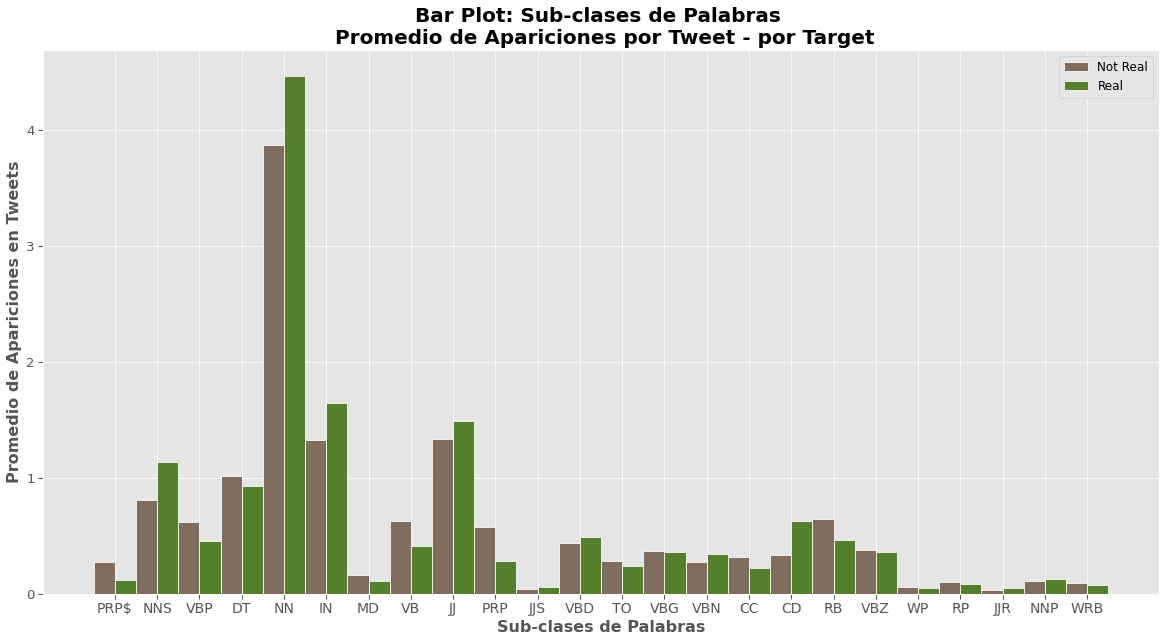

In [90]:
# set width of bar
barWidth = 0.50
 
# set height of bar
target_0_subclases = barplot.iloc[0,:].values
target_1_subclases = barplot.iloc[1,:].values
xticks_word_tags=list(barplot.iloc[0,:].index)

# Set position of bar on X axis
r1 = np.arange(len(target_0_subclases))
r2 = [x + barWidth for x in r1]
 
# Make the plot
fig=plt.figure(figsize=(20,10))
plt.bar(r1, target_0_subclases, color='#7f6d5f', width=barWidth, edgecolor='white', label='Not Real')
plt.bar(r2, target_1_subclases, color='#557f2d', width=barWidth, edgecolor='white', label='Real')
 
# Labels and titles
plt.xlabel('Sub-clases de Palabras', fontweight='bold',fontsize=16)
plt.ylabel('Promedio de Apariciones en Tweets', fontweight='bold',fontsize=16)
plt.xticks([r + 0.25 for r in range(len(target_0_subclases))],xticks_word_tags,rotation='horizontal',fontsize=14)
plt.title('Bar Plot: Sub-clases de Palabras \n Promedio de Apariciones por Tweet - por Target', fontweight='bold',fontsize=20)

# Create legend & Show graphic
plt.legend(fontsize=12)
plt.show()


In [0]:
#Vamos a volver a utilizar este dataframe para agrupar las sub-clases en clases y poder realizar el análisis por clase. 
word_classes_aggregation = train_no_duplicates_merge_word_classes[agg_cols]
word_classes_aggregation = word_classes_aggregation.reindex(sorted(word_classes_aggregation.columns),axis=1)


In [92]:
#Vemos cuales son todas las subclases. 
print(word_classes_aggregation.columns[:-1])
print(len(word_classes_aggregation.columns[:-1]))

Index(['$', '''', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'MD',
       'NN', 'NNP', 'NNS', 'PDT', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP',
       'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP',
       'WP$', 'WRB'],
      dtype='object')
35


In [0]:
#Acá estamos agregando las 35 sub-clases en 14 clases. 
word_classes_aggregation['nouns']=word_classes_aggregation['NN']+word_classes_aggregation['NNP']+word_classes_aggregation['NNS']
word_classes_aggregation['verbs']=word_classes_aggregation['VB']+word_classes_aggregation['VBD']+word_classes_aggregation['VBG']+\
                                  word_classes_aggregation['VBN']+word_classes_aggregation['VBP']+word_classes_aggregation['VBZ']+\
                                  word_classes_aggregation['MD']
word_classes_aggregation['adjectives']=word_classes_aggregation['JJ']+word_classes_aggregation['JJR']+word_classes_aggregation['JJS']
word_classes_aggregation['pronouns']=word_classes_aggregation['PRP']+word_classes_aggregation['PRP$']+word_classes_aggregation['WP']+word_classes_aggregation['WP$']
word_classes_aggregation['determiners']=word_classes_aggregation['PDT']+word_classes_aggregation['DT']+word_classes_aggregation['WDT']
word_classes_aggregation['adverbs']=word_classes_aggregation['RB']+word_classes_aggregation['RBR']+word_classes_aggregation['RBS']+\
                                            word_classes_aggregation['RP']+word_classes_aggregation['WRB']+word_classes_aggregation['EX']
word_classes_aggregation['prepositions']=word_classes_aggregation['IN']+word_classes_aggregation['TO']
word_classes_aggregation['conjuctions']=word_classes_aggregation['CC']
word_classes_aggregation['numerals_cardinals']=word_classes_aggregation['CD']
word_classes_aggregation['foreing_words']=word_classes_aggregation['FW']
word_classes_aggregation['quotes']=word_classes_aggregation["''"]
word_classes_aggregation['$']=word_classes_aggregation['$']
word_classes_aggregation['interjections']=word_classes_aggregation['UH']
word_classes_aggregation['symbols']=word_classes_aggregation['SYM']

In [94]:
word_classes=word_classes_aggregation[['nouns','verbs','adjectives','pronouns','determiners','adverbs','prepositions','conjuctions','numerals_cardinals','interjections',\
                                       'foreing_words','quotes','$','symbols','target']]
word_classes

,nouns,verbs,adjectives,pronouns,determiners,adverbs,prepositions,conjuctions,numerals_cardinals,interjections,foreing_words,quotes,$,symbols,target
0,3.00,3.00,1.00,2.00,3.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
1,4.00,0.00,2.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
2,7.00,7.00,1.00,0.00,2.00,0.00,4.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1
3,5.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,1
4,5.00,3.00,1.00,0.00,2.00,1.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6884,4.00,2.00,0.00,1.00,2.00,2.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1
6885,8.00,3.00,1.00,0.00,3.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
6886,9.00,4.00,1.00,1.00,0.00,1.00,2.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1
6887,6.00,5.00,2.00,0.00,2.00,4.00,5.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,1


In [0]:
word_classes_by_target=word_classes.groupby('target').agg(['sum','mean','std','min','max','count'])

In [96]:
word_classes_by_target_mean=word_classes.groupby('target').mean()
word_classes_by_target_mean=word_classes_by_target_mean.loc[:,word_classes_by_target_mean.sum()>0.05].round(2)
word_classes_by_target_mean

,nouns,verbs,adjectives,pronouns,determiners,adverbs,prepositions,conjuctions,numerals_cardinals
target,,,,,,,,,
0,4.78,2.85,1.40,0.90,1.06,0.87,1.60,0.31,0.34
1,5.72,2.52,1.58,0.44,0.97,0.65,1.88,0.22,0.63


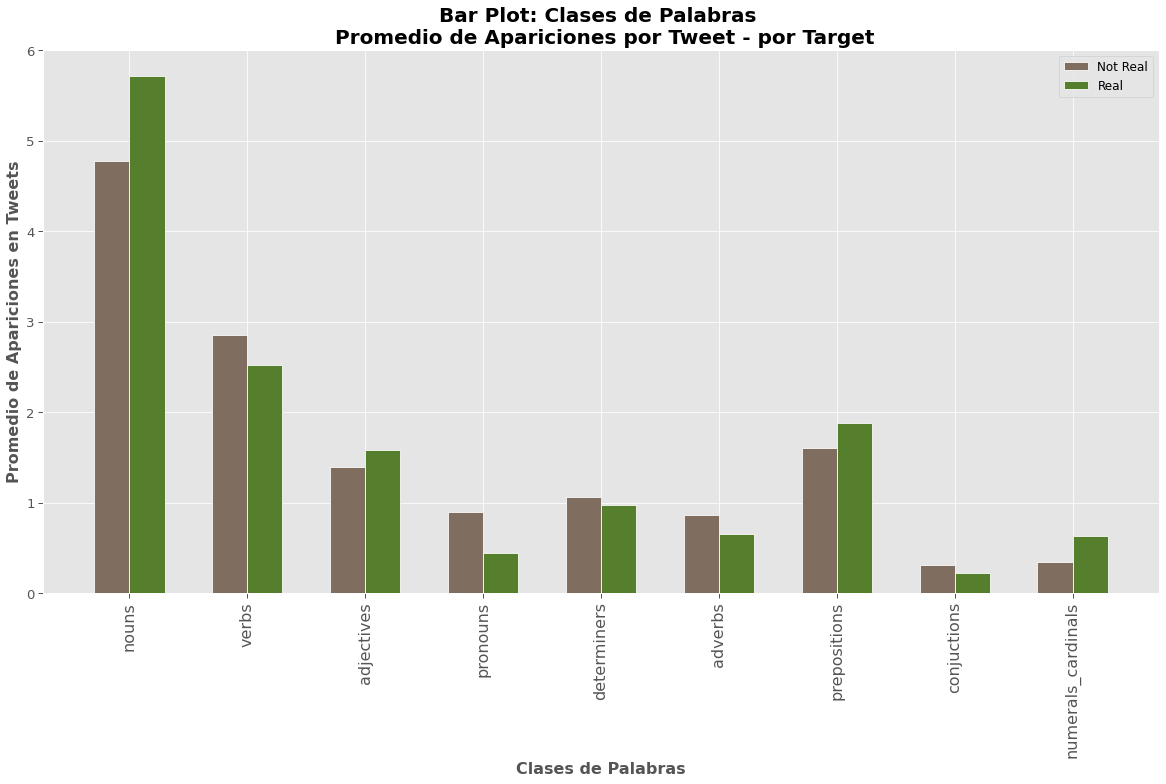

In [98]:
# set width of bar
barWidth = 0.30
 
# set height of bar
target_0 = word_classes_by_target_mean.iloc[0,:].values
target_1 = word_classes_by_target_mean.iloc[1,:].values
xticks_word_tags=list(word_classes_by_target_mean.iloc[0,:].index)

# Set position of bar on X axis
r1 = np.arange(len(target_0))
r2 = [x + barWidth for x in r1]
 
# Make the plot
fig=plt.figure(figsize=(20,10))
plt.bar(r1, target_0, color='#7f6d5f', width=barWidth, edgecolor='white', label='Not Real')
plt.bar(r2, target_1, color='#557f2d', width=barWidth, edgecolor='white', label='Real')
 
# Labels and titles
plt.xlabel('Clases de Palabras', fontweight='bold',fontsize=16)
plt.ylabel('Promedio de Apariciones en Tweets', fontweight='bold',fontsize=16)
plt.xticks([r + 0.15 for r in range(len(target_0))],xticks_word_tags,rotation='vertical',fontsize=16)
plt.title('Bar Plot: Clases de Palabras \n Promedio de Apariciones por Tweet - por Target', fontweight='bold',fontsize=20)

# Create legend & Show graphic
plt.legend(fontsize=12)
plt.show()



In [99]:
#A cuánto se va el porcentaje de target 1 en la muestra cuando en el mismo texto se combinan verbos con advervios
word_classes[(word_classes.loc[:,'verbs']>=1) & (word_classes.loc[:,'adverbs']>=1)]['target'].mean()

0.35257016713970357

In [100]:
#A cuánto se va el porcentaje de target 1 en la muestra cuando en el mismo texto tenemos sustantivos pero no pronombres. 
word_classes[(word_classes.loc[:,'nouns']>=1) & (word_classes.loc[:,'pronouns']==0)]['target'].mean()

0.5057063149885874

In [101]:
#Otra prob cond. 
word_classes[(word_classes.loc[:,'nouns']>=1) & (word_classes.loc[:,'pronouns']==0) & (word_classes.loc[:,'prepositions']>=1) & \
             (word_classes.loc[:,'numerals_cardinals']>=1) & (word_classes.loc[:,'adjectives']>=1) & (word_classes.loc[:,'adverbs']==0)]['target'].mean()

0.6746323529411765

In [105]:
#Cuántos registros representan del total. 
(word_classes[(word_classes.loc[:,'nouns']>=1) & (word_classes.loc[:,'pronouns']==0) & (word_classes.loc[:,'prepositions']>=1) & \
             (word_classes.loc[:,'numerals_cardinals']>=1) & (word_classes.loc[:,'adjectives']>=1) & (word_classes.loc[:,'adverbs']==0)].shape[0])/word_classes.shape[0]

0.07896646828276964

In [125]:
#Otra prob cond. 
1-word_classes[(word_classes.loc[:,'prepositions']==0) & 
             (word_classes.loc[:,'numerals_cardinals']==0) & (word_classes.loc[:,'adjectives']==0) & (word_classes.loc[:,'adverbs']>1)]['target'].mean()

0.8

In [126]:
#Cuántos refistros representa
(word_classes[(word_classes.loc[:,'prepositions']==0) & 
             (word_classes.loc[:,'numerals_cardinals']==0) & (word_classes.loc[:,'adjectives']==0) & (word_classes.loc[:,'adverbs']>1)].shape[0])/word_classes.shape[0]

0.0058063579619683555

In [0]:
word_classes['target'].mean()

<function matplotlib.pyplot.show>

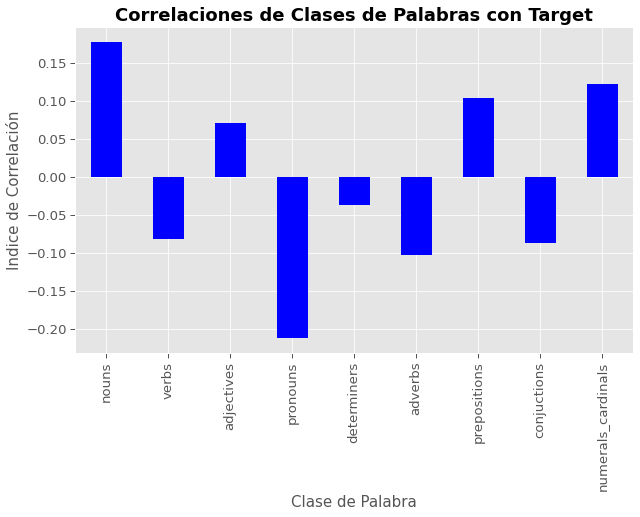

In [102]:
#Correlaciono clase con target
corr_cols=['nouns','verbs','adjectives','pronouns','determiners','adverbs','prepositions','conjuctions','numerals_cardinals','target']
(word_classes.loc[:,corr_cols].corr())['target'][:-1].plot(kind='bar', color='blue', figsize=(10,6))
plt.title('Correlaciones de Clases de Palabras con Target',fontweight='bold', fontsize=18)
plt.ylabel('Indice de Correlación', fontsize=15)
plt.xlabel('Clase de Palabra', fontsize=15)
plt.show

In [0]:
#Veamos cuales son los verbs de target 0 
verbs_target_0=[]
for x in train_no_duplicates[train_no_duplicates.loc[:,'target']==0]['pos_tagged_text']:
  for word,pos in x:
    if (pos == 'VB' or pos == 'VBD' or pos == 'VBG' or pos == 'VBN' or pos == 'VBP' or pos == 'VBZ' or pos == 'MD'): #'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ' , 'MD'
      verbs_target_0.append(word)

verbs_target_0=pd.DataFrame(verbs_target_0)
verbs_target_0.columns=['verb']
verbs_target_0['len']=verbs_target_0.verb.apply(lambda x: len(x))
verbs_target_0=verbs_target_0[verbs_target_0.loc[:,'len']>3] #Nos sacamos los verbos que tienen menos de tres letras

#Los verbs de target 1
verbs_target_1=[]
for x in train_no_duplicates[train_no_duplicates.loc[:,'target']==1]['pos_tagged_text']:
  for word,pos in x:
    if (pos == 'VB' or pos == 'VBD' or pos == 'VBG' or pos == 'VBN' or pos == 'VBP' or pos == 'VBZ' or pos == 'MD'): #'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'MD'
      verbs_target_1.append(word)

verbs_target_1=pd.DataFrame(verbs_target_1)
verbs_target_1.columns=['verb']
verbs_target_1['len']=verbs_target_1.verb.apply(lambda x: len(x))
verbs_target_1=verbs_target_1[verbs_target_1.loc[:,'len']>3] #Nos sacamos los verbos que tienen menos de tres letras


In [0]:
verbs_target_0['verb'].value_counts().head()

In [0]:
verbs_target_1.verb.value_counts().head()

In [0]:
#Veamos cuales son los nouns de target 0 
nouns_target_0=[]
for x in train_no_duplicates[train_no_duplicates.loc[:,'target']==0]['pos_tagged_text']:
  for word,pos in x:
    if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS'):
      nouns_target_0.append(word)

nouns_target_0=pd.DataFrame(nouns_target_0)
nouns_target_0.columns=['noun']
nouns_target_0['len']=nouns_target_0.noun.apply(lambda x: len(x))
nouns_target_0=nouns_target_0[nouns_target_0.loc[:,'len']>1] #Nos sacamos los sustantivos que tienen un solo caracter

#Los verbs de target 1
nouns_target_1=[]
for x in train_no_duplicates[train_no_duplicates.loc[:,'target']==1]['pos_tagged_text']:
  for word,pos in x:
    if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS'):
      nouns_target_1.append(word)

nouns_target_1=pd.DataFrame(nouns_target_1)
nouns_target_1.columns=['noun']
nouns_target_1['len']=nouns_target_1.noun.apply(lambda x: len(x)) #Obtenemos el length
nouns_target_1=nouns_target_1[nouns_target_1.loc[:,'len']>1] #Nos sacamos los sustantivos que tienen un solo caracter

In [0]:
nouns_target_0['noun'].value_counts().head()

In [0]:
nouns_target_1['noun'].value_counts().head()

In [0]:
#Veamos cuales son los nouns de target 0 
adjectives_target_0=[]
for x in train_no_duplicates[train_no_duplicates.loc[:,'target']==0]['pos_tagged_text']:
  for word,pos in x:
    if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS'): #'JJ', 'JJR', 'JJS'
      adjectives_target_0.append(word)

adjectives_target_0=pd.DataFrame(adjectives_target_0)
adjectives_target_0.columns=['adjective']
adjectives_target_0['len']=adjectives_target_0.adjective.apply(lambda x: len(x))
adjectives_target_0=adjectives_target_0[adjectives_target_0.loc[:,'len']>1] #Nos sacamos los sustantivos que tienen un solo caracter

#Los verbs de target 1
adjectives_target_1=[]
for x in train_no_duplicates[train_no_duplicates.loc[:,'target']==1]['pos_tagged_text']:
  for word,pos in x:
    if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS'): #'JJ', 'JJR', 'JJS'
      adjectives_target_1.append(word)

adjectives_target_1=pd.DataFrame(adjectives_target_1)
adjectives_target_1.columns=['adjective']
adjectives_target_1['len']=adjectives_target_1.adjective.apply(lambda x: len(x))
adjectives_target_1=adjectives_target_1[adjectives_target_1.loc[:,'len']>1] #Nos sacamos los sustantivos que tienen un solo caracter


In [0]:
adjectives_target_0.adjective.value_counts().head()

In [0]:
adjectives_target_1.adjective.value_counts().head()

# Análisis de Pronombres

Se propone un análisis de cantidad de apariciones de pronombres en tweets según su target.

In [0]:
def generate_tokens(target):
    text_tokens=[]
    for x in train_no_duplicates[train_no_duplicates['target']==target]['text_clean'].str.split():
        for i in x:
            text_tokens.append(i)
    return text_tokens

#Analizo tweets con target Not Real
corpus=generate_tokens(0)

dic=defaultdict(int)
pronouns={'I','me','my','mine','myself','you','your','yours','yourself',\
          'he','him','his','himself','she','her','hers','herself',\
          'it','its','itself','we','us','our','ours','ourselves',\
          'they','them','their','theirs','themselves','yourselves'}

for word in corpus:
    if word in pronouns:
        dic[word]+=1
        
top0=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:11]


#Analizo tweets con target Real

text_tokens=generate_tokens(1)
dic=defaultdict(int)

for word in text_tokens:
    if word in pronouns:
        dic[word]+=1

top1=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:11]



In [0]:
pronouns0=pd.DataFrame(top0,columns=['pronoun','cantidad_not_real'])
pronouns1=pd.DataFrame(top1,columns=['pronoun','cantidad_real'])

pronouns=pronouns0.merge(pronouns1, how='inner')
pronouns['cantidad_not_real']=100*pronouns['cantidad_not_real']/len(train0)
pronouns['cantidad_real']=100*pronouns['cantidad_real']/len(train1)

# Setting the positions and width for the bars
pos = list(range(len(pronouns['pronoun']))) 
width = 0.25 

# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

# Create a bar with cantidad_not_real data,
# in position pos,
plt.bar(pos, 
        #using df['pre_score'] data,
        pronouns['cantidad_not_real'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with label the first value in first_name
        label=pronouns['pronoun'][0]) 

# Create a bar with mid_score data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        pronouns['cantidad_real'],
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5,  
        # with label the second value in first_name
        label=pronouns['pronoun'][1]) 

# Set the y axis label
ax.set_ylabel('Porcentaje de apariciones por target')

# Set the chart's title
ax.set_title('Top 10 de pronombres en tweets')


# Set the position of the x ticks
ax.set_xticks([p + 0.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(pronouns['pronoun'])


# Adding the legend and showing the plot
plt.legend(['Not Real', 'Real'], loc='upper right')
plt.show()

En la figura se observan los pronombres con más apariciones para ambos targets. Se observa que los mismos 10 pronombres aparecen en ambos rankings. Sin embargo, todos los porcentajes de aparición de target Not Real superan a los de target Real. En partircular, los valores de "I", "you" y "my" para los targets Not Real triplican en porcentaje a los de target Real. 
La naturaleza de un tweet que expresa un desastre responde a un estilo de redacción con poca cantidad de pronombres respecto a un tweet "normal". Esto puede deberse a que no suele usarse la primera ni segunda persona del singular, y puede haber mayor cantidad de nombres propios.

# Wordclouds: palabras más utilizadas según target

In [0]:
link='https://drive.google.com/open?id=1HX-1ZTbIXNVLzXIvhEBAPskz53MVXPtx'
fluff, id2 = link.split('=')
print (id2) # Verify that you have everything after '='

In [0]:
downloaded = drive.CreateFile({'id':id2}) 
downloaded.GetContentFile('twitter_mask.png')

In [0]:
textWordcloud0=(train_no_duplicates[train_no_duplicates['target']==0]['text_clean_no_sw']).str.cat(sep=' ')
wave_mask = np.array(Image.open('twitter_mask.png'))
wordcloud0 = WordCloud(background_color='white',mask=wave_mask).generate(textWordcloud0)
# Display the generated image:
f, axes = plt.subplots( figsize=(20, 10), sharex=True)
plt.imshow(wordcloud0, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()



In [0]:
textWordcloud1=(train_no_duplicates[train_no_duplicates['target']==1]['text_clean_no_sw']).str.cat(sep=' ')
wordcloud1 = WordCloud(background_color='white',mask=wave_mask).generate(textWordcloud1)
# Display the generated image:
f, axes = plt.subplots( figsize=(20, 10), sharex=True)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

# N-gramas

 **1-grama**

Target=0

In [0]:
tokenized=textWordcloud0.split()
unigrams_0 = ngrams(tokenized, 1)
unigramsFreq_0 = collections.Counter(unigrams_0)
unigramsFreq_0.most_common(20)


Target=1

In [0]:
tokenized=textWordcloud1.split()
unigrams_1 = ngrams(tokenized, 1)
unigramsFreq_1 = collections.Counter(unigrams_1)
unigramsFreq_1.most_common(20)


**2-gramas**


Target=0

In [0]:
tokenized=textWordcloud0.split()
bigrams_0 = ngrams(tokenized, 2)
bigramsFreq_0 = collections.Counter(bigrams_0)
bigramsFreq_0.most_common(20)



Target= 1

In [0]:
tokenized=textWordcloud1.split()
bigrams_1 = ngrams(tokenized, 2)
bigramsFreq_1 = collections.Counter(bigrams_1)
bigramsFreq_1.most_common(20)

**3-grama**

Target=0

In [0]:
tokenized=textWordcloud0.split()
trigrams_0 = ngrams(tokenized, 3)
trigramsFreq_0 = collections.Counter(trigrams_0)
trigramsFreq_0.most_common(20)

Target=1

In [0]:
tokenized=textWordcloud1.split()
trigrams_1 = ngrams(tokenized, 3)
trigramsFreq_1 = collections.Counter(trigrams_1)
trigramsFreq_1.most_common(20)

In [0]:
unigrams_frecuencies0 = pd.DataFrame.from_dict(unigramsFreq_0, orient='index').reset_index()
unigrams_frecuencies1 = pd.DataFrame.from_dict(unigramsFreq_1, orient='index').reset_index()
unigrams_frecuencies_inner=pd.merge(unigrams_frecuencies0,unigrams_frecuencies1,on='index')
unigrams_frecuencies_outer=pd.merge(unigrams_frecuencies0,unigrams_frecuencies1,on='index', how='outer')

In [0]:
unigrams_frecuencies_inner.columns=['words','target0','target1']
unigrams_frecuencies_inner['total']=unigrams_frecuencies_inner['target0']+unigrams_frecuencies_inner['target1']

In [0]:
unigrams_frecuencies_inner.sort_values(by='total', ascending=False)

In [0]:
unigrams_frecuencies_outer.fillna(0,inplace=True)

In [0]:
unigrams_frecuencies_outer.columns=['words','target0','target1']
unigrams_frecuencies_outer['total']=unigrams_frecuencies_outer['target0']+unigrams_frecuencies_outer['target1']

In [0]:
unigrams_frecuencies_outer.sort_values(by='total', ascending=False)